# Data Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import defaultdict

import textwrap
import json

from typing import List, Dict, Tuple, Any
from math import prod
from scipy.stats import pointbiserialr

# Trainset and Testset loading

In [2]:
train_set_path = "../data/train.jsonl" 
test_set_path = "../data/test.jsonl"

df_train = pd.read_json(train_set_path, lines=True)
df_test = pd.read_json(test_set_path, lines=True)

X = df_train.drop(columns=['player_won'])
Y = df_train['player_won']

# Labels
We're working with 10,000 training samples, and the dataset is split right down the middle. The first half are all P1 wins, and the second half are all P2 wins, giving us a perfect 50/50 balance.

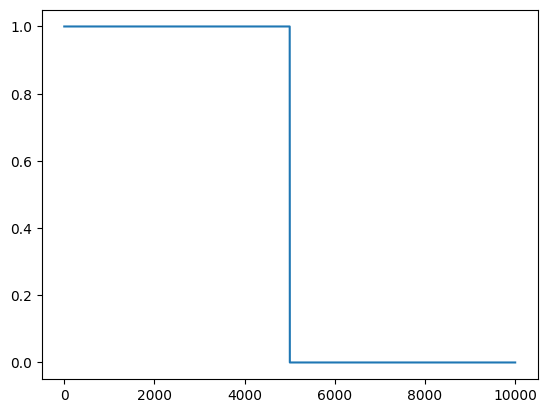

In [3]:
plt.plot(Y)
plt.show()

# Pokemons inside the dataset: 

Analysis of pokemons in P1 team an P2 lead


### 20 different Pokemons are used in the train set. 

In [4]:
pokemons_p1 = {
    pokemon['name']: pokemon['types']
    for team in X['p1_team_details']
    for pokemon in team
}
pokemons_p2 = {
    pokemon['name']: pokemon['types']   
    for pokemon in X['p2_lead_details']
}
pokemons_p1.update(pokemons_p2)
print(f'Number of Pokemons used: {len(pokemons_p1)}')

Number of Pokemons used: 20


### Pokemons relative frequency

<b>Observations:</b>

- Some Pokemons are used in almost every battle

In [5]:
pokemon_counter_p1 = Counter(
    pokemon['name']
    for team in X['p1_team_details']
    for pokemon in team
)
pokemon_counter_p2 = Counter()
for lead in X['p2_lead_details']:
    pokemon_counter_p2[lead['name']] += 1
total_pokemon_counter = pokemon_counter_p1 + pokemon_counter_p2

df_pokemons = pd.DataFrame.from_dict(pokemons_p1, orient='index', columns=['Type 1', 'Type 2'])
df_pokemons['Total Count'] = df_pokemons.index.map(total_pokemon_counter)
df_pokemons = df_pokemons.replace('notype', np.nan).reset_index(names='Pokemon')

df_pokemons

,Pokemon,Type 1,Type 2,Total Count
0,starmie,psychic,water,6578
1,exeggutor,grass,psychic,8256
2,chansey,normal,NaN,8665
3,snorlax,normal,NaN,8450
4,tauros,normal,NaN,9156
5,alakazam,NaN,psychic,7496
6,jynx,ice,psychic,4348
7,slowbro,psychic,water,1080
8,gengar,ghost,poison,3954
9,rhydon,ground,rock,2643


## Stats

In [6]:
stats_pokemons = {
    pokemon['name']: {'hp' : pokemon['base_hp'],
                     'attack' : pokemon['base_atk'],
                     'defense' : pokemon['base_def'],
                     'sp_attack' : pokemon['base_spa'],
                     'sp_defense' : pokemon['base_spd'],
                     'speed' : pokemon['base_spe']}
    for team in X['p1_team_details']
    for pokemon in team
}
stats_df = pd.DataFrame.from_dict(stats_pokemons, orient='index')

stats_df.index.name = 'Pokemon'
stats_df['Total'] = stats_df.sum(axis=1)
stats_df

,hp,attack,defense,sp_attack,sp_defense,speed,Total
Pokemon,,,,,,,
starmie,60,75,85,100,100,115,535
exeggutor,95,95,85,125,125,55,580
chansey,250,5,5,105,105,50,520
snorlax,160,110,65,65,65,30,495
tauros,75,100,95,70,70,110,520
alakazam,55,50,45,135,135,120,540
jynx,65,50,35,95,95,95,435
slowbro,95,75,110,80,80,30,470
gengar,60,65,60,130,130,110,555


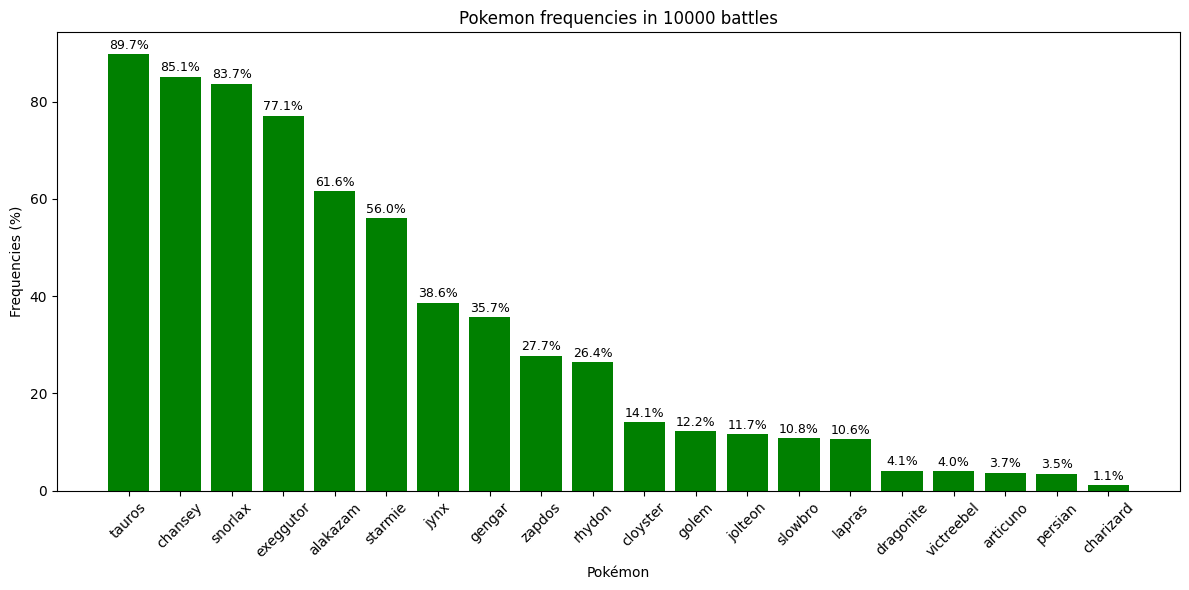

In [7]:
battle_presence_counter = Counter()

for p1_team, p2_lead in zip(X['p1_team_details'], X['p2_lead_details']):
    
    unique_pokemon_in_this_battle = {pokemon['name'] for pokemon in p1_team}
    unique_pokemon_in_this_battle.add(p2_lead['name'])
    
    battle_presence_counter.update(unique_pokemon_in_this_battle)


total_pokemon_counter = battle_presence_counter.most_common()
pokemons_names = [item[0] for item in total_pokemon_counter]
pokemons_frequencies = [item[1] for item in total_pokemon_counter]

battles = 10000

percentages = [(freq / battles) * 100 for freq in pokemons_frequencies]

plt.figure(figsize=(12, 6))
bars = plt.bar(pokemons_names, percentages, color='green')

for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2., percentage + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.xlabel('Pokémon')
plt.ylabel('Frequencies (%)') 
plt.title(f'Pokemon frequencies in {battles} battles')
plt.tight_layout()
plt.show()

## Moves

In [8]:
moves = {}
move_counter = Counter()

for battle in X['battle_timeline']:
    for turn in battle:
        for prefix in ['p1', 'p2']:
            move = turn.get(f'{prefix}_move_details')
            if move:
                name = move.get('name')
                move_counter[name] += 1  
                if name not in moves:
                    moves[name] = {
                        'base_power': move.get('base_power'),
                        'type': move.get('type'),
                        'accuracy': move.get('accuracy'),
                        'category': move.get('category')
                    }

df_moves = pd.DataFrame.from_dict(moves, orient='index')
df_moves['usage_count'] = df_moves.index.map(move_counter)
df_moves = df_moves.sort_values(by='usage_count', ascending=False).reset_index().rename(columns={'index': 'move_name'})
df_moves

,move_name,base_power,type,accuracy,category,usage_count
0,bodyslam,85,NORMAL,1.00,PHYSICAL,71755
1,psychic,90,PSYCHIC,1.00,SPECIAL,56425
2,thunderwave,0,ELECTRIC,1.00,STATUS,44617
3,blizzard,120,ICE,0.90,SPECIAL,34002
4,thunderbolt,95,ELECTRIC,1.00,SPECIAL,27386
5,icebeam,95,ICE,1.00,SPECIAL,27076
6,seismictoss,1,FIGHTING,1.00,PHYSICAL,20955
7,earthquake,100,GROUND,1.00,PHYSICAL,18705
8,sleeppowder,0,GRASS,0.75,STATUS,17520
9,softboiled,0,NORMAL,1.00,STATUS,16777


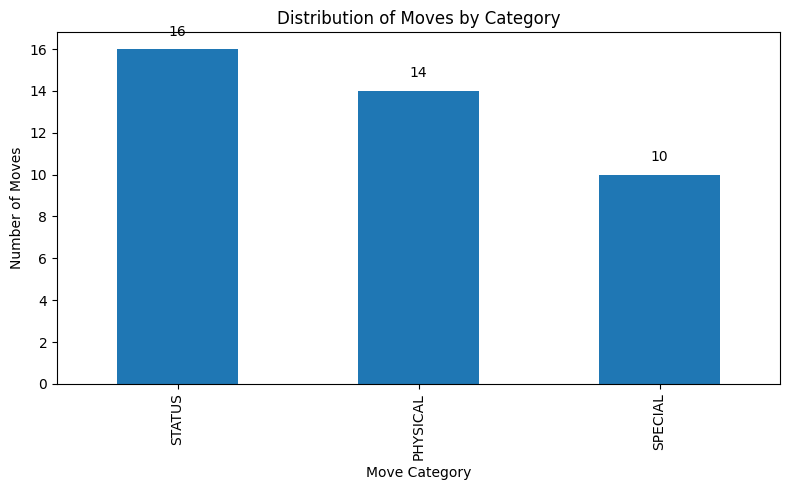

In [9]:
category_counts = df_moves['category'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar')

plt.title("Distribution of Moves by Category")
plt.xlabel("Move Category")
plt.ylabel("Number of Moves")

for i, count in enumerate(category_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Levels
There are pokemon which levels are not maxed out. However the are just a few and they battle with eachother

In [10]:
levels = set()
for p1_team, p2_lead in zip(X['p1_team_details'], X['p2_lead_details']):
    found_lv55 = False
    for pokemon in p1_team:
        if pokemon['level'] == 55:
            found_lv55 = True
            break 

    if found_lv55:
        
        p1_lead_level = p1_team[0]['level']
        
        p2_lead_level = p2_lead['level']
        
        print(f"P1 Lead Level: {p1_lead_level} | P2 Lead Level: {p2_lead_level}")

P1 Lead Level: 55 | P2 Lead Level: 55
P1 Lead Level: 55 | P2 Lead Level: 55


# Status
Looking at the status conditions: paralysis (par), freeze (frz), burn (brn), toxic (tox), poison (psn), and sleep (slp), along with the no status state, a few patterns are immediately obvious.

First, statuses like brn, tox, and psn are practically nonexistent, dwarfed by the high frequency of slp, frz, and par. This strongly suggests the latter group will be far more influential on the battle outcomes.

We also see a distinct trend linked to the winner. In the first 5,000 battles (which P1 wins), P1 generally has a higher count of no status turns and suffers from fewer status conditions overall compared to P2.

This trend completely reverses in the last 5,000 battles. Here, P2 (the winner) tends to have the higher no status count, while P1 is afflicted with more status conditions

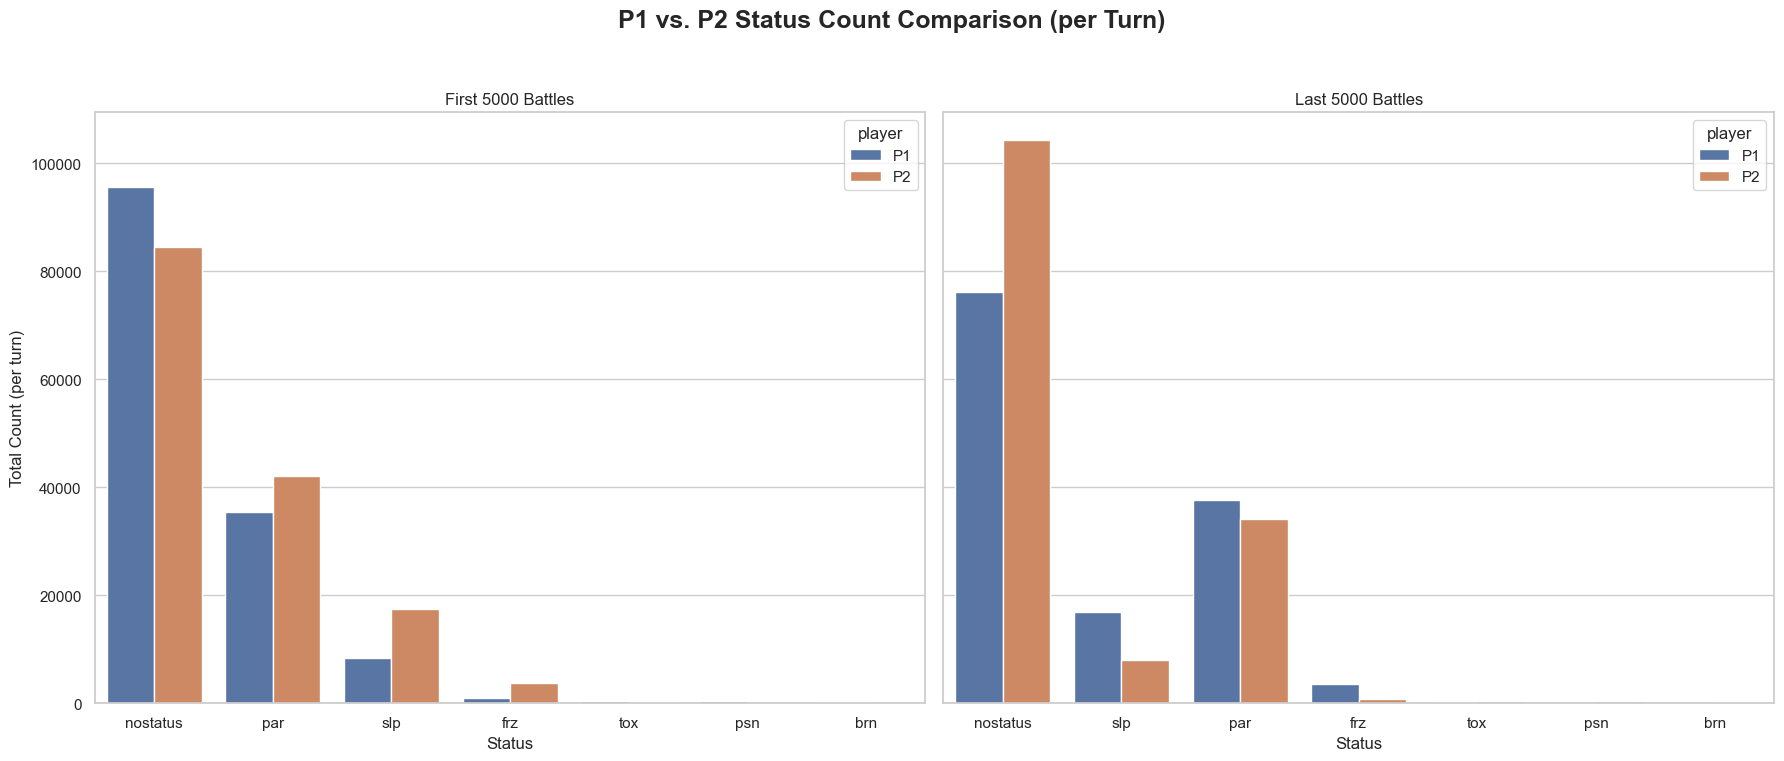

In [11]:
def count_statuses_in_battles(battle_list):
    p1_counter = Counter()
    p2_counter = Counter()
    
    for battle in battle_list:
        for turn in battle:
            status_p1 = turn['p1_pokemon_state'].get('status')
            status_p2 = turn['p2_pokemon_state'].get('status')
            
            if status_p1 and status_p1 != 'fnt':
                p1_counter[status_p1] += 1
            if status_p2 and status_p2 != 'fnt':
                p2_counter[status_p2] += 1
                
    return p1_counter, p2_counter

def counter_to_df(counter, player_label, period_label):
    return (
        pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
        .reset_index(names='status')
        .assign(player=player_label, period=period_label)
    )

p1_status_first_5000, p2_status_first_5000 = count_statuses_in_battles(X['battle_timeline'][:5000])
p1_status_last_5000, p2_status_last_5000 = count_statuses_in_battles(X['battle_timeline'][5000:])

counters_to_process = [
    (p1_status_first_5000, 'P1', 'First 5000'),  
    (p2_status_first_5000, 'P2', 'First 5000'), 
    (p1_status_last_5000,  'P1', 'Last 5000'),   
    (p2_status_last_5000,  'P2', 'Last 5000')  
]

full_df = pd.concat([
    counter_to_df(counter, player, period) 
    for counter, player, period in counters_to_process
])

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
fig.suptitle('P1 vs. P2 Status Count Comparison (per Turn)', fontsize=18, fontweight='bold') # <-- Tradotto

sns.barplot(
    data=full_df[full_df['period'] == 'First 5000'], 
    x='status', 
    y='count', 
    hue='player', 
    ax=axes[0],
)
axes[0].set_title('First 5000 Battles') 
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Total Count (per turn)') 

sns.barplot(
    data=full_df[full_df['period'] == 'Last 5000'], 
    x='status', 
    y='count', 
    hue='player', 
    ax=axes[1],
)
axes[1].set_title('Last 5000 Battles') 
axes[1].set_xlabel('Status')
axes[1].set_ylabel('') 

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Effects
Regarding the effects, they all occur quite rarely except for Reflect, which appears slightly more often, this move halves the physical damage taken by the user's team for several turns, providing a notable defensive advantage. We initially wanted to give some weight to Confusion as a feature, since being confused is usually quite troublesome during battles, but it happens far too infrequently to have any real statistical impact. There are also other effects such as Clamp, Fire Spin, and Wrap, which apply a damage-over-time effect at the end of each turn, making them quite annoying as well. However, they occur in less than 1% of all battles.

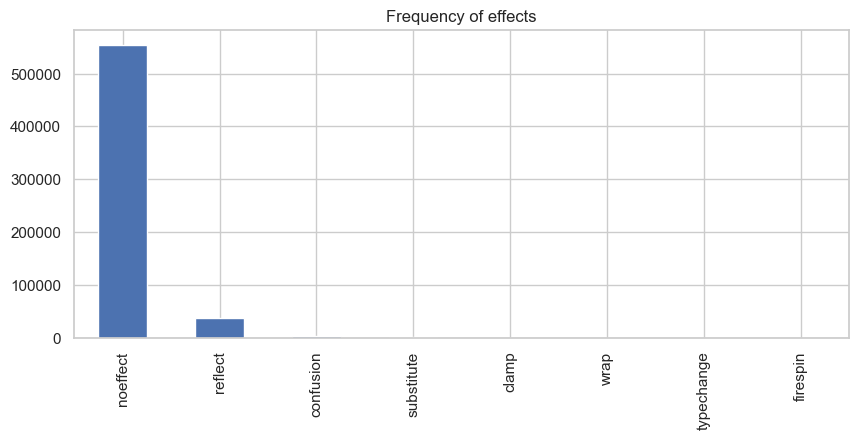

In [12]:
def count_effects_in_battles(battle_list):
    counter = Counter()
    for battle in battle_list:
        for turn in battle:
            effects_p1 = turn['p1_pokemon_state'].get('effects', [])
            effects_p2 = turn['p2_pokemon_state'].get('effects', [])
            
            all_effects = []
            if effects_p1:
                all_effects.extend(effects_p1)
            if effects_p2:
                all_effects.extend(effects_p2)
            
            for effect in all_effects:
                counter[effect] += 1
    return counter

counter = count_effects_in_battles(X['battle_timeline'][1:])
pd.Series(counter).sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title='Frequency of effects')
plt.show()

There are 129 battles that end in fewer than 30 turns, so we can be certain that one player wins and the other loses. We also notice that row 4877 has a wrong label

In [13]:
battles_with_6_faint = []

for i, battle in enumerate(X['battle_timeline']):
    p1_fnt = p2_fnt = 0
    for turn in battle:
        if turn.get("p1_pokemon_state", {}).get("status") == "fnt":
            p1_fnt += 1
        if turn.get("p2_pokemon_state", {}).get("status") == "fnt":
            p2_fnt += 1

    if p1_fnt == 6 or p2_fnt == 6:
        battles_with_6_faint.append({
            "battle_index": i,
            "winner": "p2" if p1_fnt == 6 else "p1",
            "p1_faint": p1_fnt,
            "p2_faint": p2_fnt
        })

print(f"Found {len(battles_with_6_faint)} battles where one player fainted all 6 Pokémon.")
battles_with_6_faint 


Found 129 battles where one player fainted all 6 Pokémon.


[{'battle_index': 4877, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 3},
 {'battle_index': 5017, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 0},
 {'battle_index': 5050, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 0},
 {'battle_index': 5053, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 1},
 {'battle_index': 5104, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 0},
 {'battle_index': 5180, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 2},
 {'battle_index': 5371, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 2},
 {'battle_index': 5392, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 0},
 {'battle_index': 5433, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 1},
 {'battle_index': 5436, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 1},
 {'battle_index': 5453, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 1},
 {'battle_index': 5523, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 1},
 {'battle_index': 5540, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 0},
 {'battle_index': 5641, 'winner': 'p2', 'p1_faint': 6, 'p2_faint': 2},
 {'bat